# Time Series Analysis

**Time series analysis** is analyzing data as a chronological sequence over a period. Typically if you have data with a date and/or time, you can perform time series analysis on it. Our bird strike dataset has a reliable date component with the `INCIDENT_DATE`.

Let's bring in our cleaned dataset. 

In [89]:
import pandas as pd

df = pd.read_csv('birdstrike_section2.csv', index_col='INDEX_NR', parse_dates=['INCIDENT_DATE'])

# Turn PHASE_OF_FLIGHT into a category
phase_of_flt = pd.CategoricalDtype(categories=['Parked', 'Taxi','Take-off Run', 'Approach', 'Departure', 'Climb', 'En Route',
                                               'Descent', 'Landing Roll', 'Arrival', 'Local'])

df["PHASE_OF_FLIGHT"] = df["PHASE_OF_FLIGHT"].astype(phase_of_flt)

# Turn TIME into timedelta type 
df["TIME"] = pd.to_timedelta(df["TIME"])

## Bird Strike by Date 

Let's check how many records have an `INCIDENT_DATE` provided versus not provided. 

In [91]:
df['INCIDENT_DATE'].notna().value_counts()

INCIDENT_DATE
True    141069
Name: count, dtype: int64

Great, all the records have dates provided. Let's get the `INCIDENT_DATE` and associate a strike count (1 since each record is one bird strike) in a separate dataframe. 

In [93]:
df_series = pd.DataFrame({"INCIDENT_DATE" : df["INCIDENT_DATE"], "STRIKE_COUNT" : 1})
df_series

,INCIDENT_DATE,STRIKE_COUNT
INDEX_NR,,
708307,2015-05-22,1
708308,2015-06-18,1
708309,2015-09-20,1
708310,2015-11-07,1
708311,2015-12-17,1
...,...,...
1516465,2024-03-17,1
1516467,2024-03-17,1
1516468,2024-03-17,1


Let's set the `INCIDENT_DATE` as the index. 

In [95]:
df_series.set_index('INCIDENT_DATE', inplace=True)

We can use a `resample()` function on our series so that it rolls up and sums by each week (where the `INCIDENT_DATE` is the start of each week). 

In [101]:
df_series \
 .resample("W") \
 .sum()

,STRIKE_COUNT
INCIDENT_DATE,
2015-01-04,56
2015-01-11,87
2015-01-18,103
2015-01-25,90
2015-02-01,71
...,...
2024-03-31,11
2024-04-07,4
2024-04-14,8


We can then plot this as a series of lines. 

<Axes: title={'center': 'Time Series Analysis'}, xlabel='INCIDENT_DATE'>

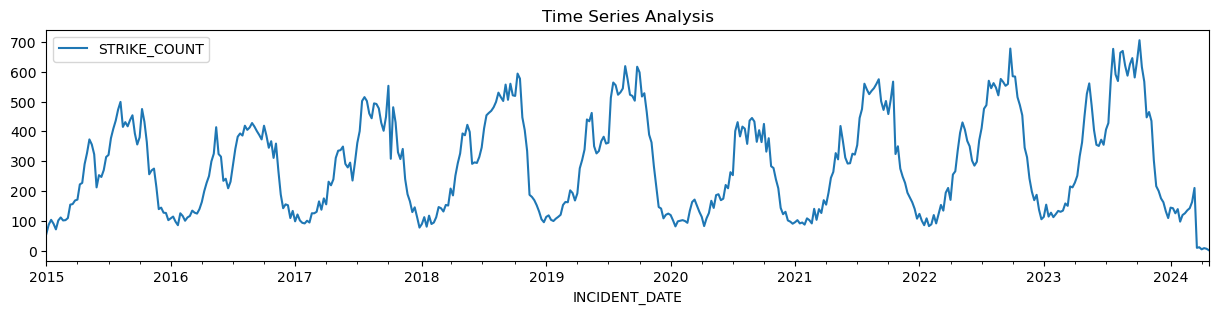

In [103]:
df_series \
 .resample("W") \
 .sum() \
 .plot(kind='line', figsize=(15,3), title="Time Series Analysis")


Oh, we see some obvous patterns here. It seems there is definitely a seasonal component where bird strikes rise going into summer, and then fall going into winter. Notice between 2020 and 2021 that bird strike incidents fell. I wonder why! 

Let's resample by month's end. 

<Axes: title={'center': 'Time Series Analysis'}, xlabel='INCIDENT_DATE'>

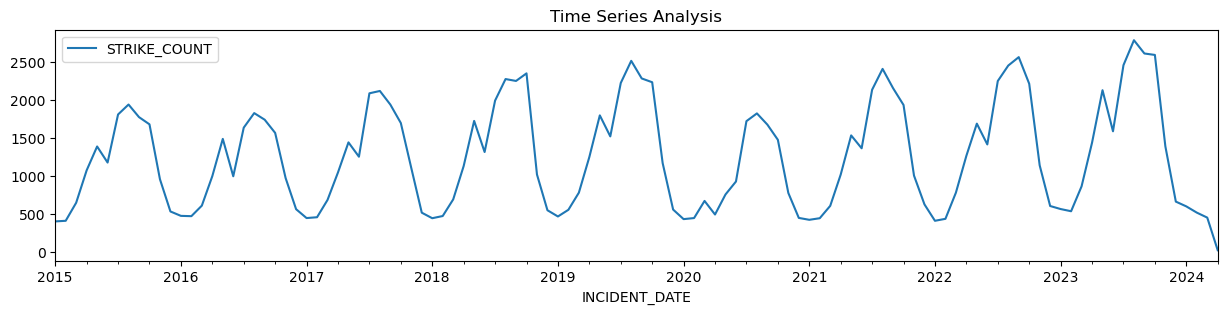

In [105]:
df_series \
 .resample("M") \
 .sum() \
 .plot(kind='line', figsize=(15,3), title="Time Series Analysis")


We don't see much of a difference other than some smoothing that occurred, as we are rolling up by month rather than week. Let' stake a look at one of these years individually and zoom into it. Let's look at 2021. 

<Axes: title={'center': 'Time Series Analysis'}, xlabel='INCIDENT_DATE'>

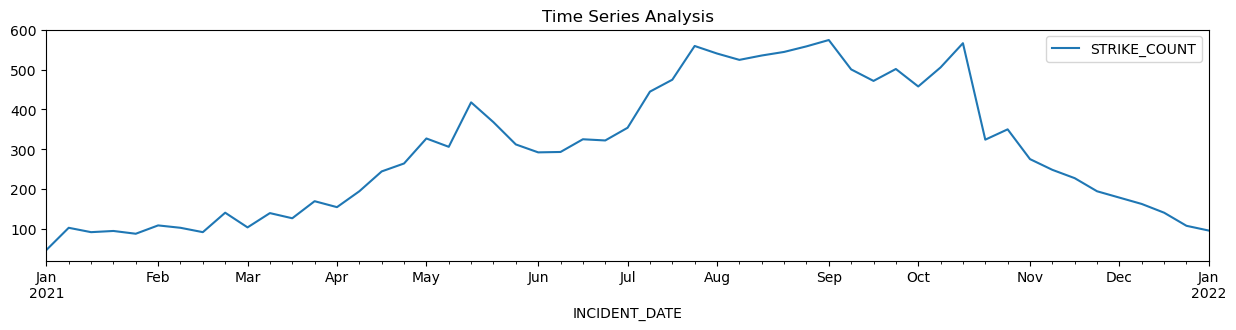

In [107]:
df_series \
 .loc["2021"] \
 .resample("W") \
 .sum() \
 .plot(kind='line', figsize=(15,3), title="Time Series Analysis")


So if this is representative of the typical cycle, we see bird strikes rise in April, and then rise again sharply after June. Then the decline starts to happen in the middle of October. 

Let's look at 2021 onwards by week. 

<Axes: title={'center': 'Time Series Analysis'}, xlabel='INCIDENT_DATE'>

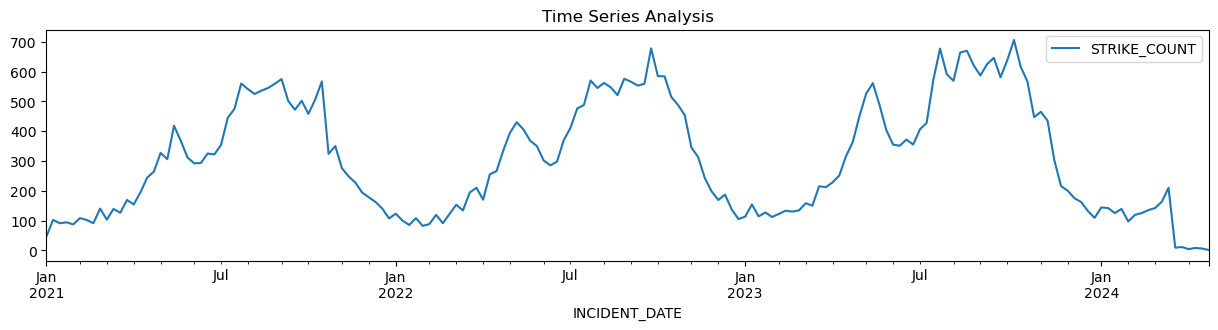

In [110]:
df_series \
 .loc["2021":] \
 .resample("W") \
 .sum() \
 .plot(kind='line', figsize=(15,3), title="Time Series Analysis")


What can you hypothesize from this? 

|<br>
|<br>
|<br>
|<br>
|<br>
|<br>
|<br>
|<br>
|<br>
v 

The reasons why we see a peak in the summer, and a dip in the winter, largely might have to do with migration patterns with birds. In North America, birds fly south for the winter, and fly north for the summer. We could also hypothesize that summer travel brings more flights, but people travel a lot in December for holidays too. If we did research this matter thoroughly, we would find according [to the FAA](https://www.faa.gov/air_traffic/publications/atpubs/aip_html/part2_enr_section_5.6.html) that "bird strike risk increases because of bird migration during the months of March through April and August through November." As a matter of fact, this is the largest factor in bird strike risk and the time series above shows! 

## Bird Strike by Time of Day 

Another way we can leverage time series is to look at the time of day. Do bird strikes happen more in the morning, middle of the day, afternoon, evening, or at night? 

Let's extract the hour out of each bird strike record and count the number of bird strikes by hour (across all dates). 

In [113]:
df_series_tm =  df["TIME"].dropna().dt.components.hours.value_counts().sort_index()
df_series_tm

hours
0     2309
1     1893
2     1285
3     1050
4     1182
5     1900
6     4464
7     8456
8     9185
9     8592
10    7606
11    6082
12    5084
13    3899
14    3894
15    3919
16    4106
17    4293
18    4301
19    4103
20    4622
21    5219
22    4866
23    4580
Name: count, dtype: int64

Let's plot this. 

<Axes: title={'center': 'Bird Strikes by Hour'}, xlabel='hours'>

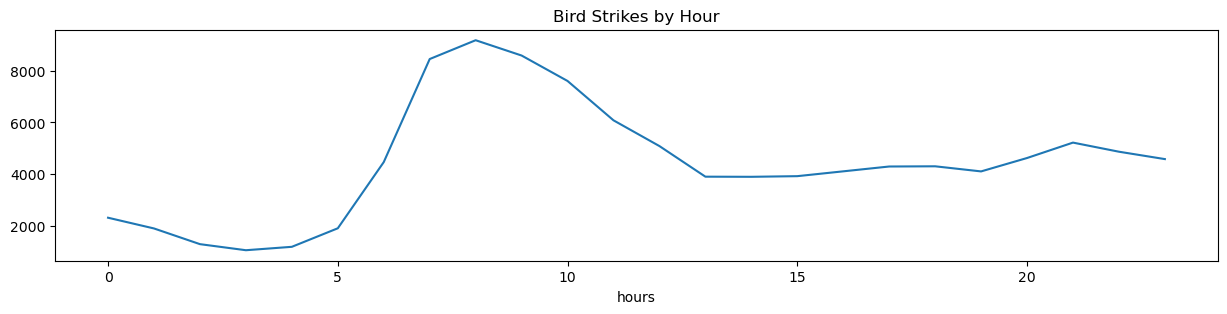

In [115]:
df_series_tm.plot(kind='line', figsize=(15,3), title="Bird Strikes by Hour")

Okay it's pretty apparent that bird strikes occur during the day, with a peak well before 10am. Makes sense that many birds would be less active at night. We could hypothesize if the less frequent night bird strikes are nocturnal birds like owls, but go down those rabbit holes on your own time. 

Let's see if we can get bird strikes by hour broken up on each month. While we can see some patterns, this looks a little awkward. 

<Axes: title={'center': 'Bird Strikes by Month and Hour'}, xlabel='MONTH,HOUR'>

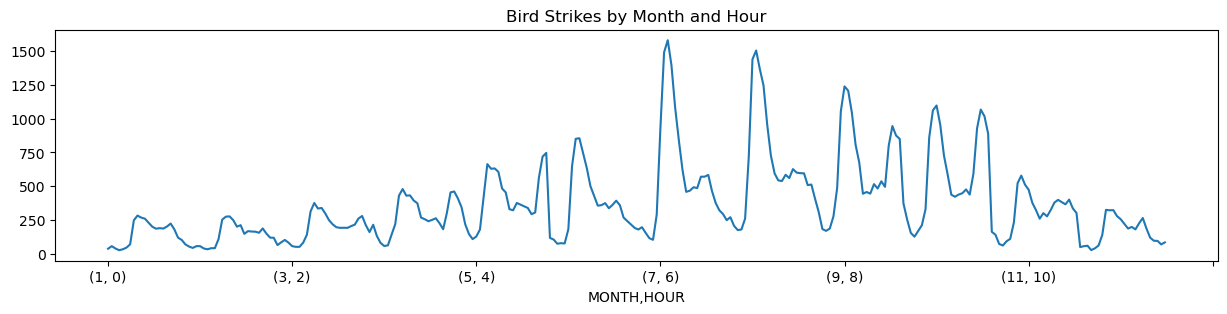

In [117]:
df_series_month_tm =  pd.DataFrame({
    "MONTH" : df[df["TIME"].notna()]["INCIDENT_DATE"].dt.month, 
    "HOUR" : df[df["TIME"].notna()]["TIME"].dt.components.hours
}).value_counts().sort_index()

df_series_month_tm.plot(kind='line', figsize=(15,3), title="Bird Strikes by Month and Hour")

Instead, we can do some grouping and pivoting to see a 24-hour time series where each month gets its own curve. This is much cleaner. 

<Axes: title={'center': 'Bird Strikes by Hour for Each Month'}, xlabel='HOUR'>

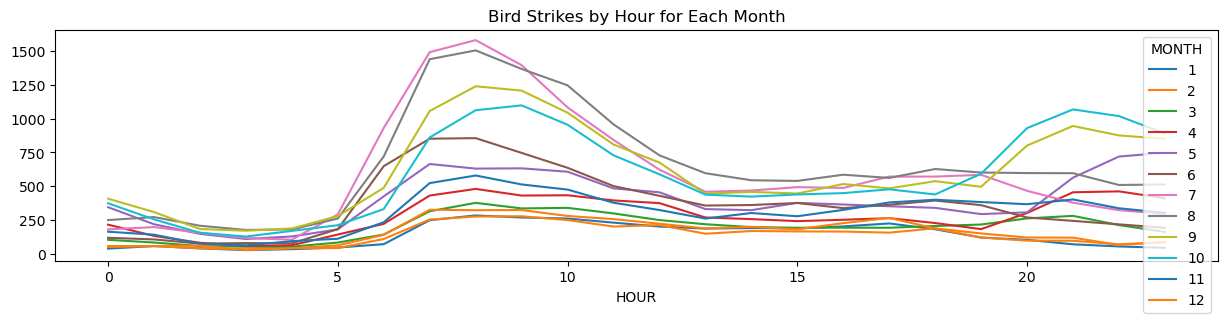

In [119]:
by_month_tm = pd.DataFrame({
    "MONTH" : df[df["TIME"].notna()]["INCIDENT_DATE"].dt.month, 
    "HOUR" : df[df["TIME"].notna()]["TIME"].dt.components.hours, 
    "STRIKES" : 1 
}).groupby(["MONTH","HOUR"]) \
.sum() \
.reset_index() \
.pivot(index="HOUR",columns="MONTH",values="STRIKES")

by_month_tm.plot(kind='line', figsize=(15,3), title="Bird Strikes by Hour for Each Month")

The peak and dip trends throughout the day generally hold for each month, where summer months are more amplified. But interestingly September (month 9), October (month 10), and May (month 5) have an uptick after 8:00pm (hour 20). These might be migratory months so perhaps there is more bird activity in later hours of the day? It's hard to say and there are many hypotheses we can explore! And we only now know to look because we did this time series analysis. 

Time series analysis is yet another way we can detect trends and patterns in our data where a chronological component is playing a role. Just be careful and always ask where the data came from! For instance, if you ingested the entire FAA bird strike dataset (and not just post-2015) you may find bird strike reports have gone up rapidly since 2008. Does this mean bird strikes have increased? No, but the reported bird strikes have increased due to more outreach and proactive reporting since the Sully incident. 

## Exercise

For our entire dataframe `df` for bird strikes since 2015, plot the total incidents by [day of week](https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.weekday.html) cumulatively for all dates and assess whether strikes happen more or less on weekends. There should only be seven discrete values on the x-axis, where 0 = Monday and 6 = Sunday. 

As a bonus, see if you can also show bird strike totals by day of week for each year. 

In [ ]:
df["INCIDENT_DATE"].dt.weekday.value_counts() \
    .sort_index() \
    .plot(xlabel="DAY OF WEEK", ylabel="INCIDENTS")

### SCROLL DOWN FOR ANSWER
|<br>
|<br>
|<br>
|<br>
|<br>
|<br>
|<br>
|<br>
|<br>
|<br>
|<br>
|<br>
|<br>
|<br>
|<br>
|<br>
|<br>
|<br>
|<br>
|<br>
|<br>
|<br>
|<br>
v 

This below will plot cumulative total incidents by day of week. 

<Axes: xlabel='DAY OF WEEK', ylabel='INCIDENTS'>

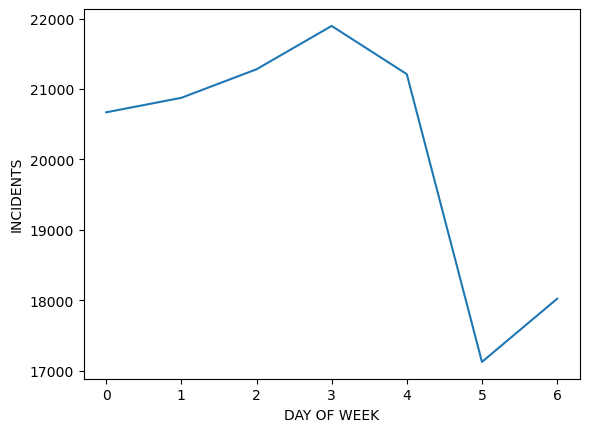

In [121]:
df["INCIDENT_DATE"].dt.weekday.value_counts() \
    .sort_index() \
    .plot(xlabel="DAY OF WEEK", ylabel="INCIDENTS")

This will plot the same thing, but for each year as a separate line. 

<Axes: title={'center': 'Bird Strikes by DOW for Each Month'}, xlabel='DOW'>

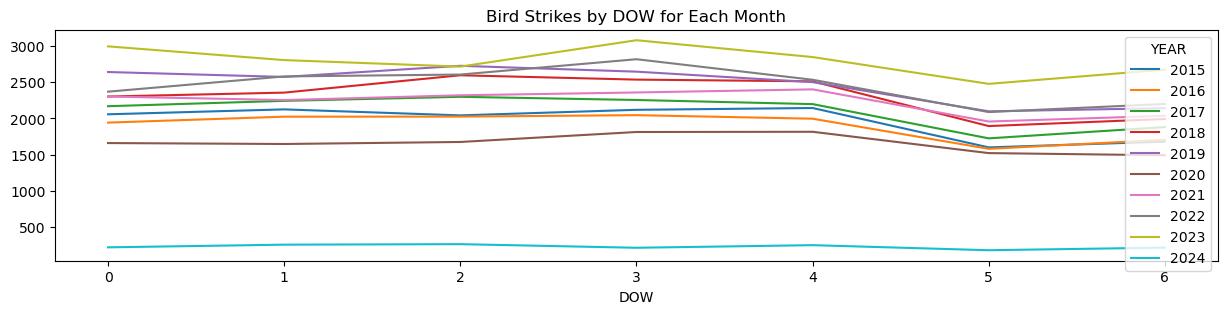

In [123]:
by_month_tm = pd.DataFrame({
    "YEAR" : df["INCIDENT_DATE"].dt.year, 
    "DOW" : df["INCIDENT_DATE"].dt.weekday,
    "STRIKES" : 1 
}).groupby(["YEAR","DOW"]) \
.sum() \
.reset_index() \
.pivot(index="DOW",columns="YEAR",values="STRIKES")

by_month_tm.plot(kind='line', figsize=(15,3), title="Bird Strikes by DOW for Each Month")